<strong><h2>Machine Learning Analysis: Multi-Model Analysis on Formatted Data</h2></strong>
- With sentiment data in mind, let's take <strong>most common token occurrences</strong> in each clinical paper and attempt to <strong>predict its assigned class.</strong> 
- We will use a multitude of multivariate classifiers (9 classes) and derive accuracy scores and confusion matrices.

In [18]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as scp
from wordcloud import STOPWORDS
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

In [3]:
TRAINING_TEXT_PATH = "./datasets/training/training_text"
df_text = pd.read_csv(TRAINING_TEXT_PATH, sep="\n")
df_text.head()

,"ID,Text"
0,0||Cyclin-dependent kinases (CDKs) regulate a ...
1,1|| Abstract Background Non-small cell lung c...
2,2|| Abstract Background Non-small cell lung c...
3,3||Recent evidence has demonstrated that acqui...
4,4||Oncogenic mutations in the monomeric Casita...


In [4]:
TRAINING_VARIANTS_PATH = "./datasets/training/training_variants"
df_variants = pd.read_csv(TRAINING_VARIANTS_PATH)
df_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
cleaned_text_data = list()
for item in df_text['ID,Text']:
    data = item.split("||")[1]
    cleaned_text_data.append(data)

In [6]:
df_text_clean = pd.DataFrame({"Clinical Evidence": cleaned_text_data})
df_text_clean.head()

,Clinical Evidence
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
df_clean = pd.concat([df_variants, df_text_clean], axis=1)
df_clean.head()

,ID,Gene,Variation,Class,Clinical Evidence
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [8]:
df_clean.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [9]:
df_class = df_clean[["Class"]]
df_class.tail()

,Class
3316,4
3317,1
3318,1
3319,4
3320,4


In [11]:
# Bind more stopwords to tokens
def _assign_stopwords(stop_words):
    for word in stop_words:
        STOPWORDS.add(word)

stop_words = ["et", "al", "â", "Figure", "figure", "fig", "Supplementary", "We", "The", "Fig.", "In", "al.", "al.,", "(Fig."]
_assign_stopwords(stop_words)

In [12]:
# Initial training and test
np.random.seed(0)
train, test = train_test_split(df_clean, test_size=0.2)

In [13]:
# Get training and testing data for X and Y
X_train = train["Clinical Evidence"].values
X_test = test["Clinical Evidence"].values
Y_train = train["Class"].values
Y_test = test["Class"].values

In [14]:
# Initialize classifier models and save to iterable list
svc = svm.LinearSVC()
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()
nbc = MultinomialNB()
clfs = [svc, rfc, dtc, nbc]

In [15]:
# Create text classifier pipeline for vectorizing, transforming, then fitting data
text_clf = Pipeline([("vect", TfidfVectorizer(lowercase=True, 
                                              stop_words="english", 
                                              encoding="utf-8")), 
                     ("tfidf", TfidfTransformer()),                    # Does inverse sparse topic mapping
                     ("clf", svc)                                      # Fits data to classifier
                    ])

In [19]:
# WARNING: Super long runtime
# TODO: Benchmark each segment to identify laggards (suspect: PIPELINE)
def model_predict(clf):
    text_clf = Pipeline([("vect", TfidfVectorizer(lowercase=True, 
                                              stop_words="english", 
                                              encoding="utf-8")), 
                     ("tfidf", TfidfTransformer()), 
                     ("clf", clf)])
    text_clf.fit(X_train, Y_train)
    Y_test_pred = text_clf.predict(X_test)
    accuracy_score = np.mean(Y_test_pred == Y_test)
    cmat = confusion_matrix(Y_test, Y_test_pred)
    return accuracy_score, text_clf

svc_acc, model = model_predict(clfs[0])
# rfc_acc, rfc_cmat = model_predict(clfs[1])
# dtc_acc, dtc_cmat = model_predict(clfs[2])
# nbc_acc, nbc_cmat = model_predict(clfs[3])

print(">> ACCURACY OF SUPPORT VECTOR CLASSIFIER IS: {:.4f}".format(svc_acc))
# print(">> ACCURACY OF RANDOM FOREST CLASSIFIER IS: {:.4f}".format(rfc_acc))
# print(">> ACCURACY OF DECISION TREE CLASSIFIER IS: {:.4f}".format(dtc_acc))
# print(">> ACCURACY OF MULTINOMIAL NAÏVE BAYES CLASSIFIER IS: {:.4f}\n".format(nbc_acc))

>> ACCURACY OF SUPPORT VECTOR CLASSIFIER IS: 0.6120


In [20]:
pkl_filename = "my_model.pkl"  
with open(pkl_filename, "wb") as file:  
    pickle.dump(model, file)

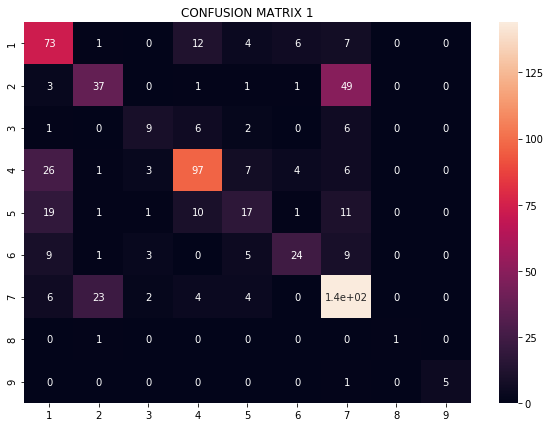

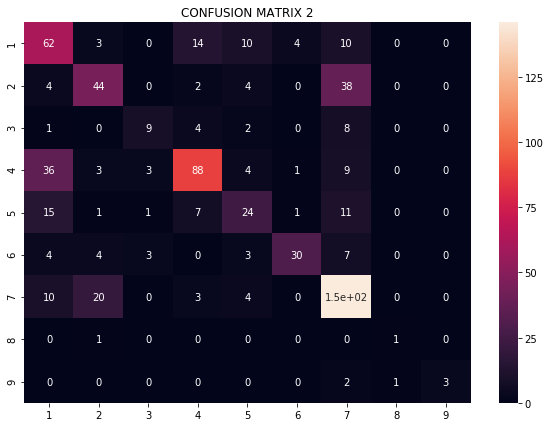

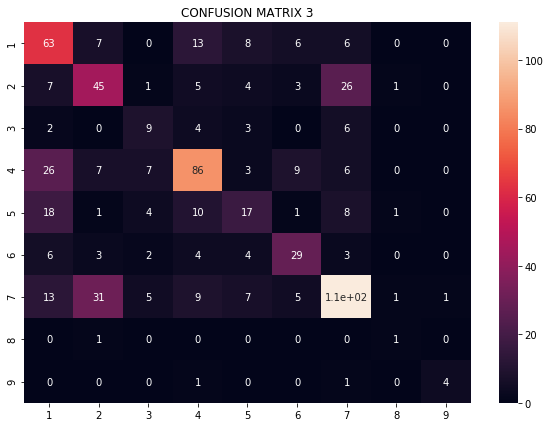

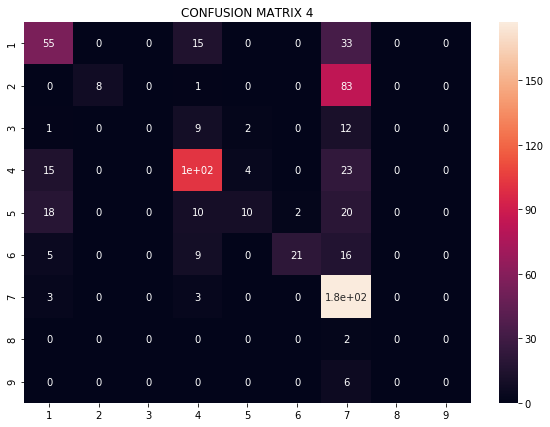

In [17]:
# CONFUSION MATRIX PLOTS
def _plot_cmat(cmat, index):
    df_cm = pd.DataFrame(cmat, index = [i for i in range(1, 10)],
                      columns = [i for i in range(1, 10)])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)
    plt.title("CONFUSION MATRIX {}".format(index + 1))

for index, item in enumerate([svc_cmat, rfc_cmat, dtc_cmat, nbc_cmat]):
    _plot_cmat(item, index)

## TODO: 
    - Scale data using StandardScaler()
    - Implement Correlation Heatmap
    - See if PCA helps
    - Visualize Decision Tree and Pipeline Process
    - Publish to Kaggle (late)
    - Create Medium post and tutorial
    - Benchmark for time and memory effectiveness
    
## NOTES:
    - BRCA1 correlates highly with onset of breast cancer
    - Check baseline prediction for class (should be 1/9 ~ 11.1%)